#Install

In [2]:
!apt-get install python3-pypdf2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-pypdf2 is already the newest version (1.26.0-2).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [3]:
!pip install -U -q PyDrive

In [4]:
!pip install sentence-transformers

In [5]:
!pip install cloudstorage

In [6]:
!pip install webapp2

In [7]:
!pip install fsspec

In [8]:
!pip install gcsfs

# Import

In [9]:
import pandas as pd
import zipfile
from google.colab import drive
import re
import time
import glob
import numpy as np
import datetime as dt
from calendar import monthrange
import nltk
import PyPDF2
from sentence_transformers import SentenceTransformer
import cloudstorage as gcs
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.metrics import f1_score

In [10]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# 10K EDA


#### Auth

In [11]:
!gcloud auth login
!gcloud auth application-default login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth&state=ut9OfDNApmv6lnZpt71RDvB9JW5qLM&prompt=consent&access_type=offline&code_challenge=wX4mGD5olqjip0S2EsRo3Ld-B1YN-vJrow2v9xdd0a4&code_challenge_method=S256

Enter verification code: 4/1AX4XfWj03I2NaPlYUmFlsdUXphHCc3wQXWPvkT_6VHTWhFAcrSTXD23cB_U

You are now logged in as [yixunz@berkeley.edu].
Your current project is [None].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID
Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?re

In [12]:
read_10k_df = pd.read_csv("gs://esgbert_resourses/raw_data/sen_res_10K_201318.csv")

/usr/local/lib/python3.7/dist-packages/google/auth/_default.py:70: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. We recommend you rerun `gcloud auth application-default login` and make sure a quota project is added. Or you can use service accounts instead. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [13]:
read_10q_df = pd.read_csv("gs://esgbert_resourses/raw_data/sen_res_10Q_201318.csv")

In [14]:
len(read_10q_df)

5944

In [46]:
read_10q_df.head()

,Unnamed: 0,origin_idx,CIK,date,total_esg_score,total_esg_score_quarter_change_pure,total_esg_score_quarter_change_pct,governance_score_quarter_change_pure,governance_score_quarter_change_pct,social_score_quarter_change_pure,social_score_quarter_change_pct,environment_score_quarter_change_pure,environment_score_quarter_change_pct,quarter,year,month,ReportType,Reports,reports_ordered,reports_cosines
0,0,38,1090872,2016-03-31,70.45,1.51,0.021434,0.01,0.000166,3.34,0.047249,0.00,0.000000,1,2016,3,10Q,0001090872-16-000070.txt : 2016060710-Q 1 a-0...,"In addition, the operation of Dako within Agil...",0.8 0.78 0.78 0.76 0.76 0.76 0.75 0.75 0.75 0....
1,1,41,1090872,2016-06-30,71.96,-2.98,-0.041412,1.20,0.019861,-10.44,-0.141024,5.43,0.066155,2,2016,6,10Q,0001090872-16-000076.txt : 2016090710-Q 1 a-0...,"In addition, the operation of Dako within Agil...",0.8 0.78 0.78 0.76 0.76 0.76 0.75 0.75 0.75 0....
2,2,47,1090872,2016-12-30,68.98,-2.73,-0.039577,0.00,0.000000,-6.05,-0.095141,0.00,0.000000,4,2016,12,10Q,0001090872-17-000004.txt : 2017030810-Q 1 a-0...,Our customers and we are subject to various go...,0.78 0.77 0.76 0.76 0.76 0.76 0.76 0.75 0.75 0...
3,3,50,1090872,2017-03-31,66.25,0.14,0.002113,0.00,0.000000,0.00,0.000000,0.55,0.006285,1,2017,3,10Q,0001090872-17-000008.txt : 2017060610-Q 1 a-0...,Our customers and we are subject to various go...,0.78 0.77 0.76 0.76 0.76 0.76 0.75 0.75 0.75 0...
4,4,53,1090872,2017-06-30,66.39,0.00,0.000000,0.00,0.000000,0.00,0.000000,0.00,0.000000,2,2017,6,10Q,0001090872-17-000013.txt : 2017090610-Q 1 a-0...,Our customers and we are subject to various go...,0.78 0.77 0.76 0.76 0.76 0.75 0.75 0.75 0.75 0...


#### MSFT analysis

In [14]:
msft_10k_df = read_10k_df[read_10k_df.CIK.isin(['789019'])]
print(len(msft_10k_df))
msft_10k_df

6


,Unnamed: 0,origin_idx,CIK,date,ReportType,total_esg_score,Reports,total_esg_score_change_10k,quarter,year,month,governance_score_change_pure_10k,social_score_change_pure_10k,environment_score_change_pure_10k,reports_ordered,reports_cosines
585,586,865,789019,2016-06-30,10K,71.03,0001193125-16-662209.txt : 2016072810-K 1 d18...,5.03,2,2016,6,1.95,-2.75,-1.57,Environmental regulations or changes in the su...,0.77 0.75 0.75 0.74 0.73 0.73 0.73 0.73 0.73 0...
586,587,866,789019,2017-06-30,10K,71.74,0001564590-17-014900.txt : 2017080210-K 1 msf...,0.71,2,2017,6,0.80,-1.02,0.84,Environmental regulations or changes in the su...,0.77 0.74 0.74 0.74 0.74 0.73 0.73 0.73 0.73 0...
587,588,867,789019,2018-06-29,10K,74.16,0001564590-18-019062.txt : 2018080310-K 1 msf...,2.42,2,2018,6,4.40,1.98,3.33,Environmental regulations or changes in the su...,0.77 0.75 0.75 0.74 0.74 0.74 0.73 0.73 0.73 0...
1515,743,862,789019,2013-06-28,10K,64.00,0001193125-13-310206.txt : 2013073010-K 1 d52...,0.00,2,2013,6,0.00,0.00,0.00,These conditions also may add uncertainty to t...,0.81 0.78 0.74 0.74 0.73 0.73 0.72 0.72 0.72 0...
1516,744,863,789019,2014-06-30,10K,66.00,0001193125-14-289961.txt : 2014073110-K 1 d72...,2.00,2,2014,6,4.00,2.00,0.00,Environmental regulations or changes in the su...,0.77 0.74 0.74 0.74 0.74 0.74 0.73 0.73 0.73 0...
1517,745,864,789019,2015-06-30,10K,66.00,0001193125-15-272806.txt : 2015073110-K 1 d91...,0.00,2,2015,6,1.00,11.00,5.00,Environmental regulations orchanges in the sup...,0.77 0.75 0.75 0.74 0.74 0.73 0.73 0.73 0.73 0...


#### All company analysis

In [15]:
cik_10k_df = read_10k_df.groupby(by='CIK').count()
print("total companies in the report:", len(cik_10k_df))

total companies in the report: 418


In [16]:
read_10k_df[['ReportType', 'CIK', 'date', 'reports_ordered']].groupby(['ReportType', 'CIK', 'date']).agg(['count'])

reports_ordered
                                        count
ReportType CIK     date                      
10K        2488    2017-12-29               1
           2969    2013-09-30               1
                   2014-09-30               1
                   2015-09-30               1
                   2016-09-30               1
...                                       ...
           1652044 2016-12-30               1
                   2017-12-29               1
           1659166 2017-12-29               1
           1681459 2017-12-29               1
           1688568 2018-03-29               1

[1784 rows x 1 columns]

In [19]:
read_10k_df[['ReportType', 'CIK', 'year', 'month', 'reports_ordered']].groupby(['ReportType', 'CIK', 'year', 'month']).agg(['count'])

reports_ordered
                                        count
ReportType CIK     year month                
10K        2488    2017 12                  1
           2969    2013 9                   1
                   2014 9                   1
                   2015 9                   1
                   2016 9                   1
...                                       ...
           1652044 2016 12                  1
                   2017 12                  1
           1659166 2017 12                  1
           1681459 2017 12                  1
           1688568 2018 3                   1

[1784 rows x 1 columns]

In [20]:
read_10k_df[['ReportType', 'year', 'reports_ordered']].groupby(['ReportType', 'year']).agg(['count'])

reports_ordered
                          count
ReportType year                
10K        2013             327
           2014             330
           2015             352
           2016             358
           2017             378
           2018              39

In [22]:
read_10k_df[['ReportType', 'year', 'month', 'reports_ordered']].groupby(['ReportType', 'year', 'month']).agg(['count'])

reports_ordered
                                count
ReportType year month                
10K        2013 3                  19
                6                  17
                9                  26
                12                265
           2014 3                  18
                6                  19
                9                  24
                12                269
           2015 3                  19
                6                  17
                9                  25
                12                291
           2016 3                  20
                6                  18
                9                  26
                12                294
           2017 3                  20
                6                  19
                9                  31
                12                308
           2018 3                  20
                6                  19

In [23]:
assert len(read_10k_df[read_10k_df.duplicated(['CIK', 'year', 'quarter', 'Reports'])]) == 0, "10K Report for every company should be just one quarterly"
assert len(read_10k_df[read_10k_df.duplicated(['CIK', 'date', 'Reports'])]) == 0, "10K Report for every company should be just one per date"
assert len(read_10k_df[read_10k_df.duplicated(['CIK', 'year'])]) == 0, "10K Report for every company should be just one per year"

In [24]:
read_10k_df.columns

Index(['Unnamed: 0', 'origin_idx', 'CIK', 'date', 'ReportType',
       'total_esg_score', 'Reports', 'total_esg_score_change_10k', 'quarter',
       'year', 'month', 'governance_score_change_pure_10k',
       'social_score_change_pure_10k', 'environment_score_change_pure_10k',
       'reports_ordered', 'reports_cosines'],
      dtype='object')

#### Cosine Similarity EDA functions

In [25]:
def get_cosines(cosine_col_name, report):
  cosines = []
  max_cosines = []
  third_cosines = []
  cosines_col = report.columns.get_loc(cosine_col_name)
  for index, row in report.iterrows():
      cosines_row = report.iloc[index, cosines_col]
      if type(cosines_row) == str:
          cosines_split = cosines_row.split()
          cosines.extend(cosines_row.split())
          max_cosines.append(max(cosines_split))
          if (len(cosines_split)) > 3:
            third_cosines.append(cosines_split[2])
  return cosines, max_cosines, third_cosines

In [26]:
def plot_cosines(cosines_type_name, cosines, plot_title):
  cosines_df = pd.DataFrame(cosines)
  cosines_df.rename(columns={0: cosines_type_name}, inplace=True)
  cosines_df[cosines_type_name] = cosines_df[cosines_type_name].astype(float)

  fig, ax = plt.subplots()

  bins = [i/10 for i in range(11)]
  ax.hist(cosines_df[cosines_type_name],
        weights=np.zeros_like(cosines_df) + 1. / cosines_df.size * 100,
        bins=bins)
  ax.set_title(plot_title)
  ax.set_ylabel('Count')
  ax.set_xlabel('Cosine')
  ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

In [27]:
def get_cosines_plots(report):
  cosines, max_cosines, third_cosines = get_cosines('reports_cosines', report)
  cosines_type = ['reports_cosines', 'max_cosines', 'third_cosines']
  plot_titles = ['Relative Frequency of Cosines of All Sentences', 'Relative Frequency of Max Cosine of Each 10K Report', 'Relative Frequency of Third Cosine of Each 10K Report']
  plot_cosines(cosines_type[0], cosines, plot_titles[0])
  plot_cosines(cosines_type[1], max_cosines, plot_titles[1])
  plot_cosines(cosines_type[2], third_cosines, plot_titles[2])

In [28]:
def esg_score_summary_with_date(report):
  eda_df = report[['date', 'total_esg_score', 'total_esg_score_change_10k',
                        'governance_score_change_pure_10k',
                        'social_score_change_pure_10k',
                        'environment_score_change_pure_10k',
                        'reports_ordered', 'reports_cosines']]

  eda_df = eda_df[(eda_df.total_esg_score.isna()==False) & (eda_df.reports_ordered.isna()==False)]
  eda_df['date'] = pd.to_datetime(eda_df.date)
  eda_df['quarter'] = eda_df['date'].dt.quarter
  eda_df['year'] = eda_df['date'].dt.year
  counts_df = eda_df[['total_esg_score', 'year', 'quarter']].groupby(by=['year','quarter']).agg('count')
  counts_df.plot()
  eda_df.hist('total_esg_score')
  eda_df.hist('total_esg_score_change_10k')
  print("Number of 10K reports have total_esg_score:", len(eda_df))
  return counts_df, eda_df

In [29]:
def plot_quarterly_score(report_df):
  qc_df = report_df[['total_esg_score_change_10k',
                          'governance_score_change_pure_10k',
                          'social_score_change_pure_10k',
                          'environment_score_change_pure_10k']]

  fig, ax = plt.subplots(2, 2, figsize=(12,8))

  fig.suptitle("Percent Distribution of Changes\nIn Quarterly Score")
  bins = [i for i in range(-10, 11, 2)]

  c = 'total_esg_score_change_10k'
  ax[0,0].hist(qc_df[c],
              weights=np.zeros_like(qc_df[c]) + 1. / qc_df[c].size * 100,
              bins=bins)
  ax[0,0].set_title('Total ESG')
  ax[0,0].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

  c = 'governance_score_change_pure_10k'
  ax[0,1].hist(qc_df[c],
              weights=np.zeros_like(qc_df[c]) + 1. / qc_df[c].size * 100,
              bins=bins)
  ax[0,1].set_title('Governance')
  ax[0,1].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

  c = 'social_score_change_pure_10k'
  ax[1,0].hist(qc_df[c],
              weights=np.zeros_like(qc_df[c]) + 1. / qc_df[c].size * 100,
              bins=bins)
  ax[1,0].set_title('Social')
  ax[1,0].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

  c = 'environment_score_change_pure_10k'
  ax[1,1].hist(qc_df[c],
              weights=np.zeros_like(qc_df[c]) + 1. / qc_df[c].size * 100,
              bins=bins)
  ax[1,1].set_title('Environment')
  ax[1,1].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))
  plt.tight_layout

In [30]:
def plot_score_by_year(eda_df, eda_columns, sub_title, bins_range):
  score_duration_df = eda_df[eda_columns]
  fig, ax = plt.subplots(2, 3, figsize=(12,8))

  fig.suptitle(sub_title)
  bins = [i for i in bins_range]

  sc = eda_columns[1]

  yrs = [[2013, 2014, 2015], [2016, 2017, 2018]]

  for row in range(2):
    for column in range(3):
      temp_df = score_duration_df[score_duration_df.year==yrs[row][column]]
      ax[row,column].hist(temp_df[sc],
                  weights=np.zeros_like(temp_df[sc]) + 1. / temp_df[sc].size * 100,
                  bins=bins)
      ax[row,column].set_title((str)(yrs[row][column]))
      ax[row,column].yaxis.set_major_formatter(mtick.PercentFormatter(decimals=0))

#### Cosine Similarity EDA Summaries and Plots

Number of 10K reports have total_esg_score: 1784


total_esg_score
year quarter                 
2013 1                     19
     2                     17
     3                     26
     4                    265
2014 1                     18
     2                     19
     3                     24
     4                    269
2015 1                     19
     2                     17
     3                     25
     4                    291
2016 1                     20
     2                     18
     3                     26
     4                    294
2017 1                     20
     2                     19
     3                     31
     4                    308
2018 1                     20
     2                     19

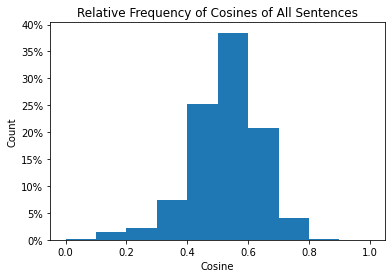

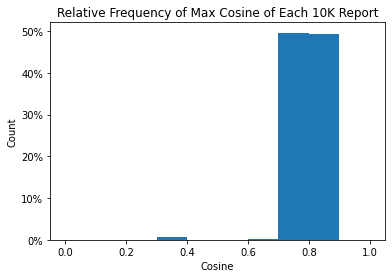

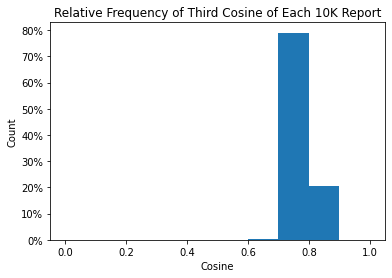

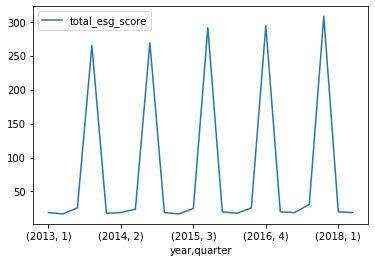

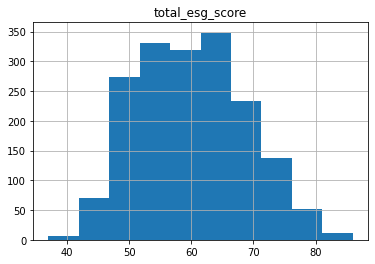

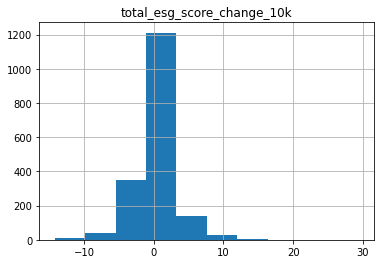

In [31]:
get_cosines_plots(read_10k_df)
counts_10k_df, eda_10k_df = esg_score_summary_with_date(read_10k_df)
counts_10k_df

In [32]:
eda_10k_df

,date,total_esg_score,total_esg_score_change_10k,governance_score_change_pure_10k,social_score_change_pure_10k,environment_score_change_pure_10k,reports_ordered,reports_cosines,quarter,year
0,2016-12-30,56.08,-2.92,-1.66,-0.38,0.80,If we fail to comply with laws and regulations...,0.76 0.75 0.75 0.75 0.75 0.74 0.74 0.74 0.74 0...,4,2016
1,2017-12-29,57.68,1.60,-4.50,-1.07,1.40,Although we believe we are positioned to accom...,0.77 0.76 0.75 0.75 0.75 0.75 0.75 0.75 0.74 0...,4,2017
2,2016-12-30,56.29,-5.71,-7.76,-12.52,1.28,In the event that any future climatechange leg...,0.81 0.79 0.78 0.78 0.77 0.76 0.76 0.75 0.75 0...,4,2016
3,2017-12-29,52.96,-3.33,-16.81,0.09,4.44,In the event that any future climate change le...,0.81 0.79 0.78 0.78 0.77 0.77 0.77 0.76 0.76 0...,4,2017
4,2017-12-29,42.31,0.00,0.00,0.00,0.00,Our wireless spectrum licenses are subject to ...,0.78 0.78 0.77 0.77 0.77 0.77 0.77 0.76 0.76 0...,4,2017
...,...,...,...,...,...,...,...,...,...,...
1779,2014-12-31,64.00,1.00,0.00,-6.00,10.00,While management believes the accruals for env...,0.8 0.79 0.78 0.75 0.75 0.74 0.74 0.74 0.74 0....,4,2014
1780,2015-12-31,58.00,-6.00,0.08,-11.64,0.11,While management believes the accruals for env...,0.8 0.78 0.75 0.75 0.74 0.74 0.74 0.74 0.74 0....,4,2015
1781,2013-12-31,64.00,0.00,0.00,0.00,0.00,Yes No x Indicate by check mar...,0.56 0.55 0.54 0.52 0.52 0.52 0.52 0.5 0.48 0....,4,2013
1782,2014-12-31,63.00,-1.00,7.00,1.00,2.00,"In addition, any significant deterioration in ...",0.76 0.76 0.75 0.75 0.74 0.74 0.71 0.71 0.71 0...,4,2014


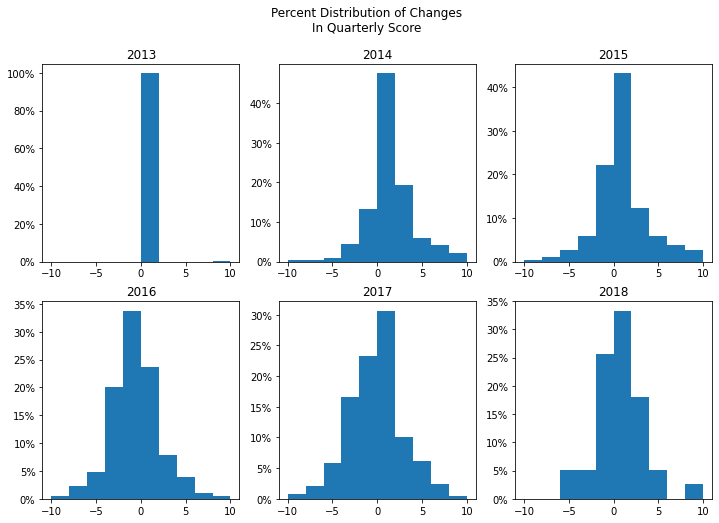

In [33]:
plot_score_by_year(eda_10k_df, ['year', 'total_esg_score_change_10k', 'reports_cosines'], "Percent Distribution of Changes\nIn Quarterly Score", range(-10, 11, 2))

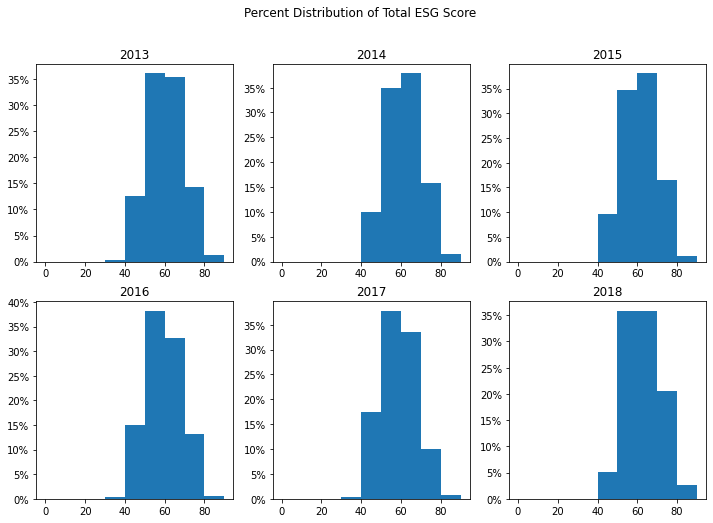

In [34]:
plot_score_by_year(eda_10k_df, ['year', 'total_esg_score', 'reports_cosines'], "Percent Distribution of Total ESG Score", range(0, 100, 10))

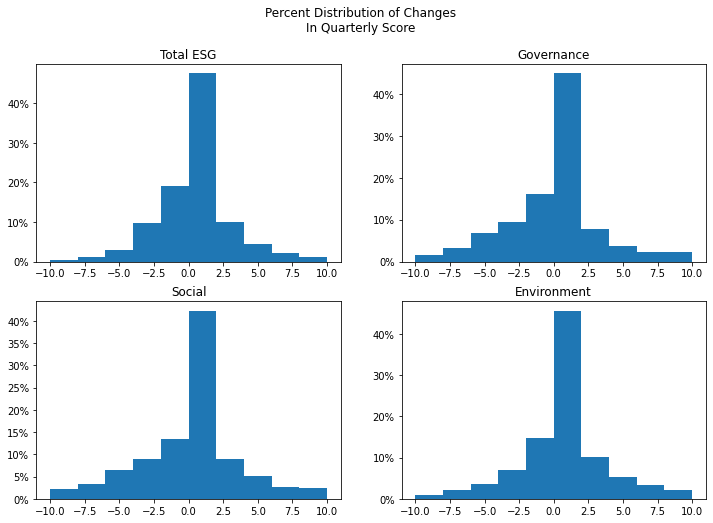

In [35]:
plot_quarterly_score(read_10k_df)

# 10K and 10Q Input and Label Datasets

In [15]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_datasets as tfds

import transformers

from transformers import BertTokenizer, TFBertModel, BertForMaskedLM, TFBertForMaskedLM
from tensorflow.keras import backend as K

import logging
from nltk.tokenize import sent_tokenize
from sklearn.utils import shuffle

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
import sklearn.metrics as metrics
from keras.regularizers import l2

tf.get_logger().setLevel(logging.ERROR)

In [16]:
def func_to_retain_order(a):
  return [a[i] for i in sorted(np.unique(a, return_index=True)[1])]

In [17]:
eda_10k_df = read_10k_df

In [21]:
eda_10q_df = read_10q_df

In [22]:
eda_10q_df['truncated_reports_ordered'] = eda_10q_df['reports_ordered'].apply(lambda row: row[0:10000])
eda_10q_df['tokenized_reports_ordered'] = eda_10q_df['truncated_reports_ordered'].apply(lambda row: sent_tokenize(row))
eda_10q_df['top_truncate_tokenized_reports_ordered'] = eda_10q_df['tokenized_reports_ordered'].apply(lambda row: row[3:])
eda_10q_df['uniq_top_truncate_tokenized_reports_ordered'] = eda_10q_df['top_truncate_tokenized_reports_ordered'].apply(lambda row: func_to_retain_order(row))
eda_10q_df['to_model_reports_col'] = eda_10q_df['uniq_top_truncate_tokenized_reports_ordered'].apply(lambda row: ''.join(row))
eda_df_10q = eda_10q_df[(eda_10q_df.year<2019) & (eda_10q_df.year>=2013)]
eda_df_10q = eda_df_10q[['CIK', 'year', 'date', 'to_model_reports_col', 'total_esg_score_quarter_change_pure']]
eda_df_10q['total_esg_score_change'] = eda_df_10q['total_esg_score_quarter_change_pure']
eda_df_10q = eda_df_10q[['CIK', 'year', 'date', 'to_model_reports_col', 'total_esg_score_change']]

In [23]:
eda_10k_df['truncated_reports_ordered'] = eda_10k_df['reports_ordered'].apply(lambda row: row[0:10000])
eda_10k_df['tokenized_reports_ordered'] = eda_10k_df['truncated_reports_ordered'].apply(lambda row: sent_tokenize(row))
eda_10k_df['top_truncate_tokenized_reports_ordered'] = eda_10k_df['tokenized_reports_ordered'].apply(lambda row: row[3:])
eda_10k_df['uniq_top_truncate_tokenized_reports_ordered'] = eda_10k_df['top_truncate_tokenized_reports_ordered'].apply(lambda row: func_to_retain_order(row))
eda_10k_df['to_model_reports_col'] = eda_10k_df['uniq_top_truncate_tokenized_reports_ordered'].apply(lambda row: ''.join(row))
eda_df_10k = eda_10k_df[(eda_10k_df.year<2019) & (eda_10k_df.year>=2013)]
eda_df_10k = eda_df_10k[['CIK', 'year', 'date', 'to_model_reports_col', 'total_esg_score_change_10k']]
eda_df_10k['total_esg_score_change'] = eda_10k_df['total_esg_score_change_10k']
eda_df_10k = eda_df_10k[['CIK', 'year', 'date', 'to_model_reports_col', 'total_esg_score_change']]

In [24]:
subset_run1_10k_df = eda_df_10k.copy()

In [25]:
subset_run1_10q_df = eda_df_10q.copy()

In [26]:
print("Total 10k reports: ", len(subset_run1_10k_df))
print("Total 10q reports: ", len(subset_run1_10q_df))

Total 10k reports:  1784
Total 10q reports:  5944


In [27]:
print("Total esg core change of 10k report is smaller than 0:", len(subset_run1_10k_df[subset_run1_10k_df.total_esg_score_change<0]))
print("Total esg core change of 10k report is larger than 0:", len(subset_run1_10k_df[subset_run1_10k_df.total_esg_score_change>0]))
print("Total esg core change of 10k report is equal to 0:", len(subset_run1_10k_df[subset_run1_10k_df.total_esg_score_change==0]))

print("Total esg core change of 10q report is smaller than 0:", len(subset_run1_10q_df[subset_run1_10q_df.total_esg_score_change<0]))
print("Total esg core change of 10q report is larger than 0:", len(subset_run1_10q_df[subset_run1_10q_df.total_esg_score_change>0]))
print("Total esg core change of 10q report is equal to 0:", len(subset_run1_10q_df[subset_run1_10q_df.total_esg_score_change==0]))

Total esg core change of 10k report is smaller than 0: 604
Total esg core change of 10k report is larger than 0: 602
Total esg core change of 10k report is equal to 0: 578
Total esg core change of 10q report is smaller than 0: 1503
Total esg core change of 10q report is larger than 0: 1282
Total esg core change of 10q report is equal to 0: 3159


In [28]:
subset_run1_10k_df['total_esg_score_change'] = np.where(abs(subset_run1_10k_df['total_esg_score_change'])==0,0,1)
subset_run1_10q_df['total_esg_score_change'] = np.where(abs(subset_run1_10q_df['total_esg_score_change'])==0,0,1)

In [29]:
split_0s_10k = np.array_split(subset_run1_10k_df[subset_run1_10k_df['total_esg_score_change'] == 0], 5)
validation_ds_0s_10k = split_0s_10k[4]
train_ds_0s_10k = pd.concat(split_0s_10k[0:4])
split_1s_10k = np.array_split(subset_run1_10k_df[subset_run1_10k_df['total_esg_score_change'] == 1], 5)
validation_ds_1s_10k = split_1s_10k[4]
train_ds_1s_10k = pd.concat(split_1s_10k[0:4])
validation_ds_10k = pd.concat([validation_ds_0s_10k, validation_ds_1s_10k]).sample(frac=1)
train_ds_10k = pd.concat([train_ds_0s_10k, train_ds_1s_10k]).sample(frac=1)

In [30]:
split_0s_10q = np.array_split(subset_run1_10q_df[subset_run1_10q_df['total_esg_score_change'] == 0], 5)
validation_ds_0s_10q = split_0s_10q[4]
train_ds_0s_10q = pd.concat(split_0s_10q[0:4])
split_1s_10q = np.array_split(subset_run1_10q_df[subset_run1_10q_df['total_esg_score_change'] == 1], 5)
validation_ds_1s_10q = split_1s_10q[4]
train_ds_1s_10q = pd.concat(split_1s_10q[0:4])
validation_ds_10q = pd.concat([validation_ds_0s_10q, validation_ds_1s_10q]).sample(frac=1)
train_ds_10q = pd.concat([train_ds_0s_10q, train_ds_1s_10q]).sample(frac=1)

In [32]:
validation_dataset_10q = tf.data.Dataset.from_tensor_slices((validation_ds_10q.to_model_reports_col.values, validation_ds_10q.total_esg_score_change.values))
validation_data_10q = validation_dataset_10q.take(len(validation_ds_10q))
train_dataset_10q = tf.data.Dataset.from_tensor_slices((train_ds_10q.to_model_reports_col.values, train_ds_10q.total_esg_score_change.values))
train_data_10q = train_dataset_10q.take(len(train_ds_10q))

In [34]:
validation_dataset_10k = tf.data.Dataset.from_tensor_slices((validation_ds_10k.to_model_reports_col.values, validation_ds_10k.total_esg_score_change.values))
validation_data_10k = validation_dataset_10k.take(len(validation_ds_10k))
train_dataset_10k = tf.data.Dataset.from_tensor_slices((train_ds_10k.to_model_reports_col.values, train_ds_10k.total_esg_score_change.values))
train_data_10k = train_dataset_10k.take(len(train_ds_10k))

In [35]:
print("Number of training dataset: ", len(train_data_10q))
print("Number of validataion dataset: ", len(validation_data_10q))

Number of training dataset:  4756
Number of validataion dataset:  1188


In [36]:
print("Number of training dataset: ", len(train_data_10k))
print("Number of validataion dataset: ", len(validation_data_10k))

Number of training dataset:  1428
Number of validataion dataset:  356


In [37]:
train_size_10k = len(train_data_10k)
validation_size_10k = len(validation_data_10k)
train_examples_batch_10k, train_labels_batch_10k = next(iter(train_data_10k.batch(train_size_10k)))
validation_examples_batch_10k, validation_labels_batch_10k = next(iter(validation_data_10k.batch(validation_size_10k)))
x_train_10k=train_ds_10k.to_model_reports_col.values
x_validation_10k=validation_ds_10k.to_model_reports_col.values
y_train_10k=train_ds_10k.total_esg_score_change.values
y_validation_10k=validation_ds_10k.total_esg_score_change.values

In [38]:
train_size_10q = len(train_data_10q)
validation_size_10q = len(validation_data_10q)
train_examples_batch_10q, train_labels_batch_10q = next(iter(train_data_10q.batch(train_size_10q)))
validation_examples_batch_10q, validation_labels_batch_10q = next(iter(validation_data_10q.batch(validation_size_10q)))
x_train_10q=train_ds_10q.to_model_reports_col.values
x_validation_10q=validation_ds_10q.to_model_reports_col.values
y_train_10q=train_ds_10q.total_esg_score_change.values
y_validation_10q=validation_ds_10q.total_esg_score_change.values

# Baseline Modeling

In [39]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(x_train_10q)
Train_X_Tfidf_10q = Tfidf_vect.transform(x_train_10q)
Test_X_Tfidf_10q = Tfidf_vect.transform(x_validation_10q)

In [40]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf_10q,y_train_10q)
predictions_SVM_10q = SVM.predict(Test_X_Tfidf_10q)
print("Base SVM Accuracy Score -> ", metrics.accuracy_score(y_validation_10q, predictions_SVM_10q))
print("Base SVM F1 Score -> ", metrics.f1_score(y_validation_10q, predictions_SVM_10q))

Base SVM Accuracy Score ->  0.49242424242424243
Base SVM F1 Score ->  0.1862348178137652


In [41]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(x_train_10k)
Train_X_Tfidf_10k = Tfidf_vect.transform(x_train_10k)
Test_X_Tfidf_10k = Tfidf_vect.transform(x_validation_10k)

In [42]:
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(Train_X_Tfidf_10k,y_train_10k)
predictions_SVM_10k = SVM.predict(Test_X_Tfidf_10k)
print("Base SVM Accuracy Score -> ", metrics.accuracy_score(y_validation_10k, predictions_SVM_10k))
print("Base SVM F1 Score -> ", metrics.f1_score(y_validation_10k, predictions_SVM_10k))

Base SVM Accuracy Score ->  0.6853932584269663
Base SVM F1 Score ->  0.8101694915254236


# Modeling With Pretrained BERT

#### Get pretrained model

In [43]:
!pip install transformers

In [44]:
!gsutil cp -r gs://esgbert_resourses/esgbert_model/model '.'

Copying gs://esgbert_resourses/esgbert_model/model/ESGMLMTunedBERT/config.json...
Copying gs://esgbert_resourses/esgbert_model/model/ESGMLMTunedBERT/pytorch_model.bin...
Copying gs://esgbert_resourses/esgbert_model/model/ESGMLMTunedBERT/training_args.bin...
| [3 files][413.4 MiB/413.4 MiB]                                                
Operation completed over 3 objects/413.4 MiB.                                    


In [45]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('./model/ESGMLMTunedBERT', from_pt=True)
bert_mlm_model = BertForMaskedLM.from_pretrained('./model/ESGMLMTunedBERT', return_dict = True)
bert_mlm_tf_model = TFBertForMaskedLM.from_pretrained('./model/ESGMLMTunedBERT', from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.p

#### Tokenize input data

In [49]:
num_train_examples_10k = train_size_10k
num_validation_examples_10k = validation_size_10k

max_length = 512

x_train_10k = tokenizer([str(x.numpy())[2:] for x in train_examples_batch_10k[:num_train_examples_10k]], 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_train_10k = train_labels_batch_10k[:num_train_examples_10k]

x_validation_10k = tokenizer([str(x.numpy())[2:] for x in validation_examples_batch_10k[:num_validation_examples_10k]], 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_validation_10k = validation_labels_batch_10k[:num_validation_examples_10k]

In [53]:
print('ratio of positive examples: ', np.sum(y_train_10k==0)/len(y_train_10k))
print('ratio of positive examples in validation: ', np.sum(y_validation_10k==0)/len(y_validation_10k))

ratio of positive examples:  0.3242296918767507
ratio of positive examples in validation:  0.32303370786516855


In [51]:
num_train_examples_10q = train_size_10q
num_validation_examples_10q = validation_size_10q

max_length = 512

x_train_10q = tokenizer([str(x.numpy())[2:] for x in train_examples_batch_10q[:num_train_examples_10q]], 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_train_10q = train_labels_batch_10q[:num_train_examples_10q]

x_validation_10q = tokenizer([str(x.numpy())[2:] for x in validation_examples_batch_10q[:num_validation_examples_10q]], 
              max_length=max_length,
              truncation=True,
              padding='max_length', 
              return_tensors='tf')
y_validation_10q = validation_labels_batch_10q[:num_validation_examples_10q]

In [52]:
print('ratio of positive examples: ', np.sum(y_train_10q==0)/len(y_train_10q))
print('ratio of positive examples in validation: ', np.sum(y_validation_10q==0)/len(y_validation_10q))

ratio of positive examples:  0.5315391084945332
ratio of positive examples in validation:  0.5311447811447811


#### Define plots of results

In [54]:
def plot_training_validation_loss(history):
  history_dict = history.history

  acc = history_dict['accuracy']
  val_acc = history_dict['val_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)
  fig = plt.figure(figsize=(10, 6))
  fig.tight_layout()

  plt.subplot(2, 1, 1)
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(2, 1, 2)
  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='lower right')
  print("The median of val_accuracy: ", np.median(val_acc))

#### Experiment and Fine-tuning And the Best Model

##### 10k - Lower learning rate & layer freezing is 3 & add a 64dense relu & a Dropout layer

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.p

Epoch 1/10
179/179 [==============================] - 49s 227ms/step - loss: 0.6648 - accuracy: 0.6672 - val_loss: 0.6643 - val_accuracy: 0.6769
Epoch 2/10
179/179 [==============================] - 38s 210ms/step - loss: 0.6538 - accuracy: 0.6755 - val_loss: 0.6657 - val_accuracy: 0.6770
Epoch 3/10
179/179 [==============================] - 38s 211ms/step - loss: 0.6401 - accuracy: 0.6810 - val_loss: 0.6639 - val_accuracy: 0.7081
Epoch 4/10
179/179 [==============================] - 38s 211ms/step - loss: 0.6055 - accuracy: 0.7189 - val_loss: 0.6441 - val_accuracy: 0.7062
Epoch 5/10
179/179 [==============================] - 38s 210ms/step - loss: 0.5821 - accuracy: 0.7312 - val_loss: 0.7079 - val_accuracy: 0.6895
Epoch 6/10
179/179 [==============================] - 38s 211ms/step - loss: 0.5547 - accuracy: 0.7387 - val_loss: 0.6281 - val_accuracy: 0.7175
Epoch 7/10
179/179 [==============================] - 38s 211ms/step - loss: 0.5296 - accuracy: 0.7517 - val_loss: 0.6755 - val_ac

<tf.Tensor: shape=(16, 1), dtype=int64, numpy=
array([[202],
       [205],
       [148],
       [ 50],
       [287],
       [209],
       [117],
       [ 94],
       [108],
       [129],
       [126],
       [431],
       [ 10],
       [189],
       [142],
       [379]])>

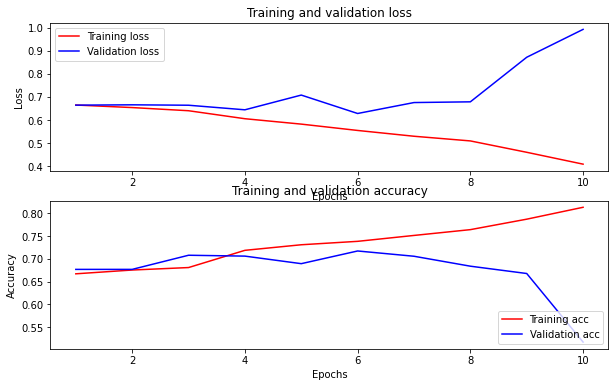

In [55]:
def create_mixed_tuning_classification_model_2_10k(hidden_size = 200, 
                                train_layers = -1, 
                                optimizer=tf.keras.optimizers.Adam(),
                                training_model=bert_model):

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                  'token_type_ids': token_type_ids,
                  'attention_mask': attention_mask}

    #restrict training to the train_layers outer transformer layers
    if not train_layers == -1:

            retrain_layers = []

            for retrain_layer_number in range(train_layers):

                layer_code = '_' + str(11 - retrain_layer_number)
                retrain_layers.append(layer_code)

            for w in training_model.weights:
                if not any([x in w.name for x in retrain_layers]):
                    w._trainable = False


    bert_out = training_model(bert_inputs)

    classification_token = tf.keras.layers.Lambda(lambda x: x, name='get_first_vector')(bert_out[0])

    hidden = tf.keras.layers.Dense(hidden_size, name='hidden_layer')(classification_token)
    hidden = tf.keras.layers.Dense(64, activation='relu',name='hidden_layer_2')(hidden)
    hidden = tf.keras.layers.Dropout(rate=0.1)(hidden)
    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], 
                                          outputs=[classification])
    
    output_classification = classification
    classification_model.compile(optimizer=optimizer,
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                            metrics='accuracy')
    return classification_model, classification

try:
    del classification_mixed_tuning_model_2_10k
except:
    pass

try:
    del bert_model
except:
    pass

tf.keras.backend.clear_session()
bert_model = TFBertModel.from_pretrained('./model/ESGMLMTunedBERT', from_pt=True)
classification_mixed_tuning_model_2_10k, classification_2_10k = create_mixed_tuning_classification_model_2_10k(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), train_layers=3)

fit_classification_mixed_tuning_model_2_10k = classification_mixed_tuning_model_2_10k.fit([x_train_10k.input_ids, x_train_10k.token_type_ids, x_train_10k.attention_mask],
                         y_train_10k,
                         validation_data=([x_validation_10k.input_ids, x_validation_10k.token_type_ids, x_validation_10k.attention_mask],
                         y_validation_10k),
                        epochs=10,
                        batch_size=8)

prediction_classification_mixed_tuning_2_10k = classification_mixed_tuning_model_2_10k.predict([x_train_10k.input_ids, x_train_10k.token_type_ids, x_train_10k.attention_mask], 
                             batch_size=8, 
                             steps=2)

plot_training_validation_loss(fit_classification_mixed_tuning_model_2_10k)
tf.argmax(prediction_classification_mixed_tuning_2_10k, axis=1)

##### 10q - Lower learning rate & layer freezing is 3 & add a 64dense relu & a Dropout layer

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFBertModel were not initialized from the PyTorch model and are newly initialized: ['bert.pooler.dense.weight', 'bert.p

Epoch 1/10
595/595 [==============================] - 136s 215ms/step - loss: 0.7138 - accuracy: 0.5313 - val_loss: 0.7102 - val_accuracy: 0.5320
Epoch 2/10
595/595 [==============================] - 125s 210ms/step - loss: 0.7099 - accuracy: 0.5334 - val_loss: 0.7073 - val_accuracy: 0.5320
Epoch 3/10
595/595 [==============================] - 125s 210ms/step - loss: 0.7008 - accuracy: 0.5509 - val_loss: 0.7475 - val_accuracy: 0.5374
Epoch 4/10
595/595 [==============================] - 125s 211ms/step - loss: 0.6771 - accuracy: 0.5970 - val_loss: 0.7307 - val_accuracy: 0.5383
Epoch 5/10
595/595 [==============================] - 125s 211ms/step - loss: 0.6664 - accuracy: 0.6135 - val_loss: 0.7433 - val_accuracy: 0.5394
Epoch 6/10
595/595 [==============================] - 125s 210ms/step - loss: 0.6596 - accuracy: 0.6162 - val_loss: 0.7535 - val_accuracy: 0.5086
Epoch 7/10
595/595 [==============================] - 126s 211ms/step - loss: 0.6507 - accuracy: 0.6347 - val_loss: 0.7634 -

<tf.Tensor: shape=(16, 1), dtype=int64, numpy=
array([[126],
       [511],
       [377],
       [511],
       [279],
       [261],
       [511],
       [125],
       [511],
       [ 37],
       [354],
       [511],
       [383],
       [274],
       [ 46],
       [314]])>

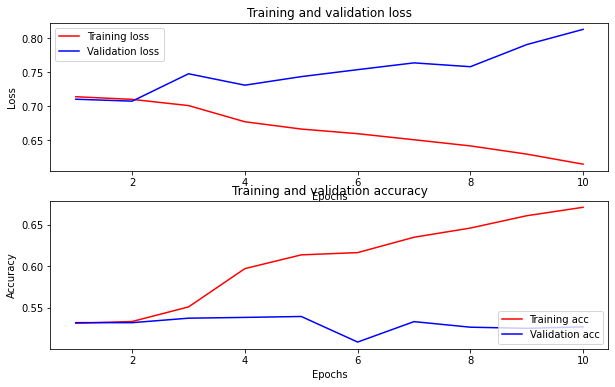

In [57]:
def create_mixed_tuning_classification_model_2_10q(hidden_size = 200, 
                                train_layers = -1, 
                                optimizer=tf.keras.optimizers.Adam(),
                                training_model=bert_model):

    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='input_ids_layer')
    token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name='attention_mask_layer')

    bert_inputs = {'input_ids': input_ids,
                  'token_type_ids': token_type_ids,
                  'attention_mask': attention_mask}

    #restrict training to the train_layers outer transformer layers
    if not train_layers == -1:

            retrain_layers = []

            for retrain_layer_number in range(train_layers):

                layer_code = '_' + str(11 - retrain_layer_number)
                retrain_layers.append(layer_code)

            for w in training_model.weights:
                if not any([x in w.name for x in retrain_layers]):
                    w._trainable = False


    bert_out = training_model(bert_inputs)

    classification_token = tf.keras.layers.Lambda(lambda x: x, name='get_first_vector')(bert_out[0])

    hidden = tf.keras.layers.Dense(hidden_size, name='hidden_layer')(classification_token)
    hidden = tf.keras.layers.Dense(64, activation='relu',name='hidden_layer_2')(hidden)
    hidden = tf.keras.layers.Dropout(rate=0.1)(hidden)
    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], 
                                          outputs=[classification])
    
    output_classification = classification
    classification_model.compile(optimizer=optimizer,
                            loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                            metrics='accuracy')
    return classification_model, classification

try:
    del classification_mixed_tuning_model_2_10q
except:
    pass

try:
    del bert_model
except:
    pass

tf.keras.backend.clear_session()
bert_model = TFBertModel.from_pretrained('./model/ESGMLMTunedBERT', from_pt=True)
classification_mixed_tuning_model_2_10q, classification_2_10q = create_mixed_tuning_classification_model_2_10q(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005), train_layers=3)

fit_classification_mixed_tuning_model_2_10q = classification_mixed_tuning_model_2_10q.fit([x_train_10q.input_ids, x_train_10q.token_type_ids, x_train_10q.attention_mask],
                         y_train_10q,
                         validation_data=([x_validation_10q.input_ids, x_validation_10q.token_type_ids, x_validation_10q.attention_mask],
                         y_validation_10q),
                        epochs=10,
                        batch_size=8)

prediction_classification_mixed_tuning_2_10q = classification_mixed_tuning_model_2_10q.predict([x_train_10q.input_ids, x_train_10q.token_type_ids, x_train_10q.attention_mask], 
                             batch_size=8, 
                             steps=2)

plot_training_validation_loss(fit_classification_mixed_tuning_model_2_10q)
tf.argmax(prediction_classification_mixed_tuning_2_10q, axis=1)